In [1]:
import pandas as pd

train_df = pd.read_csv("imdb_cleaned_data/imdb_arh_train.csv")
val_df   = pd.read_csv("imdb_cleaned_data/imdb_arh_val.csv")
test_df  = pd.read_csv("imdb_cleaned_data/imdb_arh_test.csv")

print(train_df.head())

    movie_id       movie_name  \
0  tt3652714         Guardian   
1  tt1682948    Table for Six   
2  tt0077470    Dracula's Dog   
3  tt3717070  People Who Hurt   
4  tt2514476    Jeremiah Harm   

                                         description               genre_list  \
0  After the mysterious death of her undercover c...         Action, Thriller   
1  Five years after the apparent suicide of vibra...  Drama, Mystery, Romance   
2  Communist soldiers accidentally unleash the pa...                   Horror   
3  The complex relationship between a father and ...           Drama, Romance   
4  Intergalatic bounty hunter ends up on earth on...           Action, Sci-Fi   

  csv_genre  
0    action  
1   romance  
2    horror  
3   romance  
4    action  


In [2]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_df['csv_genre'])

y_train = label_encoder.transform(train_df['csv_genre'])
y_val   = label_encoder.transform(val_df['csv_genre'])
y_test  = label_encoder.transform(test_df['csv_genre'])

num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)

Classes: ['action' 'horror' 'romance']


In [3]:
def clean_text(text):
    if isinstance(text, str):
        # remove punctuation for cleaner tokens 
        text = text.replace('.', '').replace(',', '').replace('"', '') 
        return text.lower()
    return ""

train_df['description'] = train_df['description'].apply(clean_text)
val_df['description'] = val_df['description'].apply(clean_text)
test_df['description'] = test_df['description'].apply(clean_text)

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 20000
MAX_LEN = 200   

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<UNK>")
tokenizer.fit_on_texts(train_df['description'])

X_train = tokenizer.texts_to_sequences(train_df['description'])
X_val   = tokenizer.texts_to_sequences(val_df['description'])
X_test  = tokenizer.texts_to_sequences(test_df['description'])

X_train = pad_sequences(X_train, maxlen=MAX_LEN)
X_val   = pad_sequences(X_val, maxlen=MAX_LEN)
X_test  = pad_sequences(X_test, maxlen=MAX_LEN)


c:\Users\Anish Parmar\anaconda3\envs\p4ml\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Anish Parmar\anaconda3\envs\p4ml\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Anish Parmar\anaconda3\envs\p4ml\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.1 at tensorflow/core/framework/resource_handle.proto. Please update

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from tensorflow.keras.layers import Bidirectional

model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


c:\Users\Anish Parmar\anaconda3\envs\p4ml\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/10
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 833s 391ms/step - accuracy: 0.6948 - loss: 0.7323 - val_accuracy: 0.7826 - val_loss: 0.5515
Epoch 2/10
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 835s 394ms/step - accuracy: 0.8080 - loss: 0.5275 - val_accuracy: 0.7903 - val_loss: 0.5512
Epoch 3/10
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 829s 391ms/step - accuracy: 0.8374 - loss: 0.4535 - val_accuracy: 0.7917 - val_loss: 0.5498
Epoch 4/10
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 811s 383ms/step - accuracy: 0.8562 - loss: 0.3997 - val_accuracy: 0.7859 - val_loss: 0.5812
Epoch 5/10
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 838s 396ms/step - accuracy: 0.8726 - loss: 0.3567 - val_accuracy: 0.7781 - val_loss: 0.6706
Epoch 6/10
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 843s 398ms/step - accuracy: 0.8852 - loss: 0.3155 - val_accuracy: 0.7746 - val_loss: 0.6898
Epoch 7/10
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 810s 382ms/step - accuracy: 0.8974 - loss: 0.2828 - val_accuracy: 0.7713 - val_loss: 0.7725


In [7]:
# save model
model.save("saved_models/imdb_bilstm_model_v1.keras")

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

454/454 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.7978 - loss: 0.5360
Test accuracy: 0.7978379130363464


454/454 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step


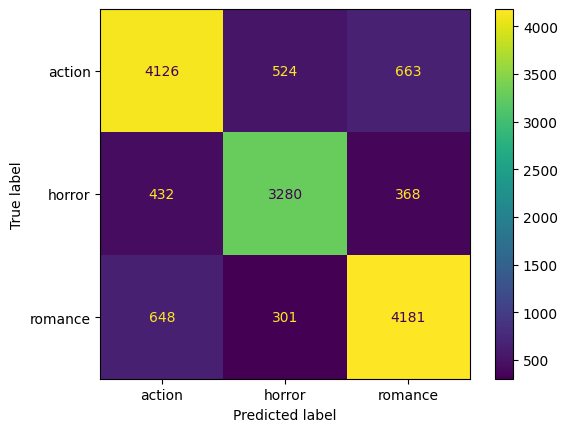

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
disp.plot()

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

      action       0.79      0.78      0.78      5313
      horror       0.80      0.80      0.80      4080
     romance       0.80      0.82      0.81      5130

    accuracy                           0.80     14523
   macro avg       0.80      0.80      0.80     14523
weighted avg       0.80      0.80      0.80     14523



In [11]:
import keras

# Define the path to your saved model file
model_path = "saved_models/imdb_bilstm_model_v1.keras"

# Reload the model
# The loaded_model will have the same architecture, weights,
# training configuration (loss, optimizer), and state as the original model.
loaded_model = keras.models.load_model(model_path)

# You can now use the loaded_model for prediction or further training
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,519,435 (32.50 MB)

 Trainable params: 2,839,811 (10.83 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,679,624 (21.67 MB)

In [12]:
test_loss, test_acc = loaded_model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

454/454 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.7978 - loss: 0.5360
Test accuracy: 0.7978379130363464


In [13]:
!pip install lime

In [14]:
import numpy as np
from lime.lime_text import LimeTextExplainer
from tensorflow.keras.preprocessing.sequence import pad_sequences

explainer = LimeTextExplainer(class_names=label_encoder.classes_)

In [15]:
predict_proba = lambda texts: loaded_model.predict(
    pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_LEN)
)

In [16]:
explicit_movies = {
    'action': 'tt0057076',       
    'horror': 'tt0117571',
    'romance': "tt1120985"
}

classes = label_encoder.classes_
examples = {}
titles = {}

for c in classes:
    # Select the row that matches the explicit movie title
    example_row = test_df[(test_df["csv_genre"] == c) & (test_df["movie_id"] == explicit_movies[c])].iloc[0]
    examples[c] = example_row["description"]
    titles[c] = example_row["movie_name"]

for c in classes:
    print(f"\n=== Example for {c} ===")
    print("Title:", titles[c])
    print("Description:", examples[c])

lime_explanations = {}

for c in classes:
    movie_title = titles[c].replace(" ", "_")  # replace spaces with underscores for filename
    exp = explainer.explain_instance(
        examples[c],
        predict_proba,
        num_features=10,
        top_labels=1
    )
    lime_explanations[c] = exp
    exp.save_to_file(f"lime_{movie_title}.html")



=== Example for action ===
Title: From Russia with Love
Description: james bond willingly falls into an assassination plot involving a naive russian beauty in order to retrieve a soviet encryption device that was stolen by spectre

=== Example for horror ===
Title: Scream
Description: a year after the murder of her mother a teenage girl is terrorized by a new killer who targets the girl and her friends by using horror films as part of a deadly game

=== Example for romance ===
Title: Blue Valentine
Description: the relationship of a contemporary married couple charting their evolution over a span of years by cross-cutting between time periods
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step


In [17]:
import webbrowser

webbrowser.open("lime_Blue_Valentine.html")

True

In [18]:
webbrowser.open("lime_From_Russia_with_Love.html")

True

In [19]:
webbrowser.open("lime_Scream.html")

True